In [2]:
#! usr/bin/env python3

## Code for classifying word data from:
https://python.gotrained.com/text-classification-with-pandas-scikit/

In [3]:
import pandas as pd
import datetime as dt
from wordcloud import WordCloud
import PIL
import itertools
import matplotlib.pyplot as plt
import re
import operator
import numpy as np
import seaborn as sns

## Import data downloaded from reddit

In [4]:
new_data_mommit = pd.read_pickle('mommit_data')
new_data_bump2017 = pd.read_pickle('bump2017_data')
new_data_ppd = pd.read_pickle('ppd_data')
new_data_babies = pd.read_pickle('babies_data')

In [5]:
new_data_mommit.head()

,title,score,id,comms_num,created,body,timestamp
Datetime,,,,,,,
2018-10-26 02:31:24,Potty training Advice. My son is scared.,1,9rgdeh,2,1.540546e+09,,2018-10-26 02:31:24
2018-10-25 23:57:31,"Talking to 4 yr old about ""Stranger Danger"" an...",34,9rf8xb,23,1.540537e+09,Hi!\n\nJust had my daughters 4 yr well check a...,2018-10-25 23:57:31
2018-10-25 23:00:05,Teen angst,7,9resak,14,1.540534e+09,My daughter just turned 13. If I try and pay a...,2018-10-25 23:00:05
2018-10-25 22:05:28,Can a 2 month old be teething,9,9reb5s,24,1.540530e+09,Is it possible for a 2 month old (almost 3 mon...,2018-10-25 22:05:28
2018-10-25 22:00:25,New to reddi,5,9re9h5,4,1.540530e+09,I’m a mom of two children I just started potty...,2018-10-25 22:00:25


In [94]:
## Define stop words (words useless in analysis)
stop_words =['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself',
            'yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself',
            'they','them','their','theirs','themselves','what','which','who','whom','this','that',
            'these','those','am','is','are','was','were','be','been','being','have','has','had',
            'having','do','does','did','doing','a','an','the','and','but','if','or','because','as',
            'until','while','of','at','by','for','with','about','against','between','into','through',
            'during','before','after','above','below','to','from','up','down','in','out','on','off',
            'over','under','again','further','then','once','here','there','when','where','why','how',
            'all','any','both','each','few','more','most','other','some','such','no','nor','not',
            'only','own','same','so','than','too','very','s','t','can','will','just','don','should',
            'now','uses','use','using','used','one','also','r',
        'baby','week','mom','moms','dad','pregnancy','pregnant','thread','chat','daily',
    'monday','tuesday','wednesday','thursday','friday','saturday','sunday',
            'mondays','tuesdays','wednesdays','thursdays','fridays','saturdays','sundays','year','old']
    
## Function to remove stop words    
def preprocess(data):
    data = data.lower() #Convert to lower-case words
    raw_word_tokens = re.findall(r'(?:\w+)', data)#,flags = re.UNICODE) #remove pontuaction
    word_tokens = [w for w in raw_word_tokens if not w in stop_words] # do not add stop words
    return word_tokens #return all tokens

## Word cloud analysis

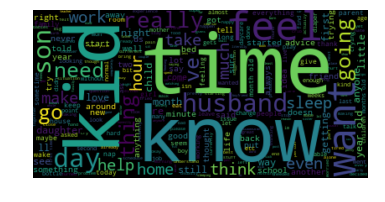

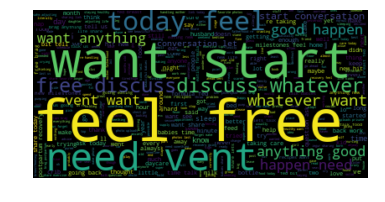

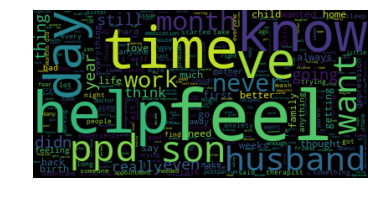

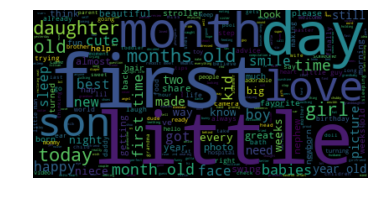

In [7]:
## Create word cloud
all_words = []
for bodytext in new_data_mommit['body']:
    all_words = all_words + preprocess(bodytext)
all_text = " ".join(all_words)
wordcloud = WordCloud(max_words=5000,margin=0).generate(all_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Create word cloud
all_words = []
for bodytext in new_data_bump2017['body']:
    all_words = all_words + preprocess(bodytext)
all_text = " ".join(all_words)
wordcloud = WordCloud(max_words=5000,margin=0).generate(all_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Create word cloud
all_words = []
for bodytext in new_data_ppd['body']:
    all_words = all_words + preprocess(bodytext)
all_text = " ".join(all_words)
wordcloud = WordCloud(max_words=5000,margin=0).generate(all_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Create word cloud
all_words = []
for bodytext in new_data_babies['title']:
    all_words = all_words + preprocess(bodytext)
all_text = " ".join(all_words)
wordcloud = WordCloud(max_words=5000,margin=0).generate(all_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [8]:
new_data_bump2017.tail()

,title,score,id,comms_num,created,body,timestamp
Datetime,,,,,,,
2018-02-12 14:42:03,Do you ladies have any fun plans for the upcom...,4,7x15jh,11,1.518475e+09,It's going to be Spring time soon here. We are...,2018-02-12 14:42:03
2018-02-12 12:36:49,Here they come!,22,7x0fs5,15,1.518468e+09,,2018-02-12 12:36:49
2018-02-12 06:16:40,"Mama Care MondayFebruary 12, 2018",2,7wyu89,4,1.518445e+09,How are YOU doing? We talk about our babies......,2018-02-12 06:16:40
2018-02-12 06:16:32,"Daily Chat Thread February 12, 2018",2,7wyu7h,28,1.518445e+09,Here is today's chat thread! Feel free to disc...,2018-02-12 06:16:32
2018-02-12 02:35:29,Help! Suspected thrush,3,7wxnhm,12,1.518432e+09,99% sure babe has thrush. She’s fussy on the ...,2018-02-12 02:35:29


## Word occurence over time

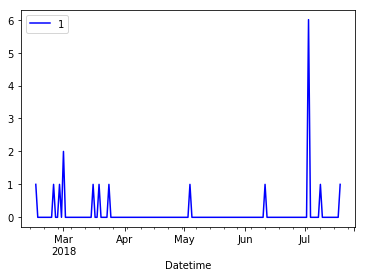

In [9]:
def word_occurence_ts(data,test_word):
    tslist = []
    for i,bodytext in enumerate(data['body']):
        for word in preprocess(bodytext):
            if word == test_word:
                tslist.append((data['timestamp'][i],1))

    df1 = pd.DataFrame(tslist)
    df1['Datetime'] = pd.to_datetime(df1[0])
    df1 = df1.set_index('Datetime')
    df1 = df1.resample('D').sum()
    return df1
    
df_new = word_occurence_ts(new_data_bump2017,'anxiety')

fig, ax = plt.subplots()
df_new.plot(ax = ax,color = 'b')
#df_hot.plot(ax = ax, color = 'r',marker = 'v',linestyle = '')

Text(0.5,1,'PPD support subreddit')

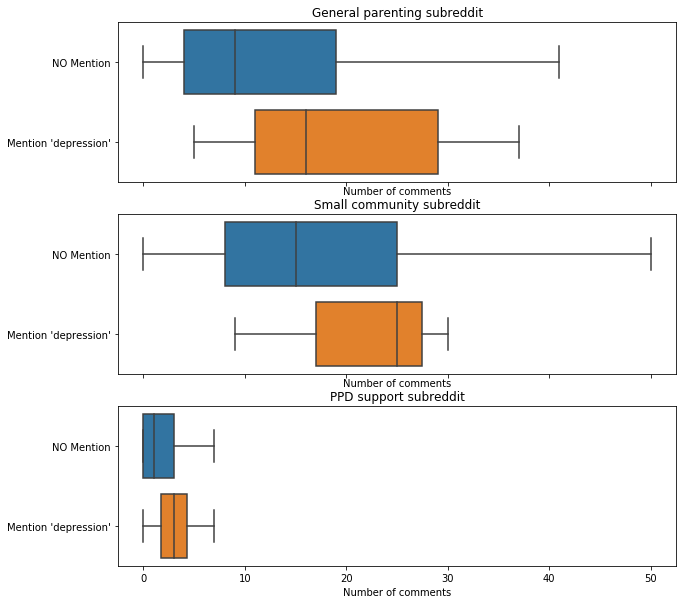

In [10]:
def word_occurence_col(data,test_words):
    tslist = list()
    flag = False
    for i,bodytext in enumerate(data):
        for word in preprocess(bodytext):
            if word in test_words:
                flag = True
        if flag: tslist.append('Mention \'depression\'')
        else: tslist.append('NO Mention')
        flag = False
    return tslist

test_words = ['depression']
'''
fig, ax = plt.subplots(3,1, sharex = True, sharey = True)

for i in range(3):
    if i == 0: dat = new_data_mommit
    elif i == 1: dat = new_data_bump2017
    elif i == 2: dat = new_data_ppd
    dat['word_use_count'] = word_occurence_col(dat['body'],test_words)
    sns.kdeplot((dat.comms_num[dat['word_use_count'] == 0]), ax = ax[i], label = 'NO Mention')
    sns.kdeplot((dat.comms_num[dat['word_use_count'] == 1]), ax = ax[i], label = 'Mention \'depression\'')
ax[2].set_xlabel('Number of comments')
ax[1].set_ylabel('Probability density')
ax[0].axis([-25,75,0,0.25])
ax[0].set_title('General open subreddit')
ax[1].set_title('Small community subreddit')
ax[2].set_title('PPD support subreddit')
'''

fig = plt.figure(figsize = (10,10))
ax = fig.subplots(3,1, sharex = True, sharey = True)

for i in range(3):
    if i == 0: dat = new_data_mommit
    elif i == 1: dat = new_data_bump2017
    elif i == 2: dat = new_data_ppd
    dat['word_use_count'] = word_occurence_col(dat['body'],test_words)
    sns.boxplot(x = 'comms_num', y = 'word_use_count', data = dat, ax = ax[i],showfliers = False,orient = 'h')
    ax[i].set_xlabel('Number of comments')
    ax[i].set_ylabel('')

    
ax[0].set_title('General parenting subreddit')
ax[1].set_title('Small community subreddit')
ax[2].set_title('PPD support subreddit')

#ax[0].xlim([-25,75])

## Classification of posts
with code and NLP procedure from: https://python.gotrained.com/text-classification-with-pandas-scikit/

In [11]:
df_train = new_data_ppd[['body','title']]
df_train['subR'] = 'ppd'
new_data_babies['subR'] = 'neutral'
df_train= df_train.append(new_data_babies[['body','title','subR']])

/home/asya/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [95]:
def preprocess_nosplit(data):
    reviews_tokens = []
    for review in data:
        review = review.lower() #Convert to lower-case words
        raw_word_tokens = re.findall(r'(?:\w+)', review,flags = re.UNICODE) #remove puntuaction
        word_tokens = [w for w in raw_word_tokens if not w in stop_words] # do not add stop words
        reviews_tokens.append(word_tokens)
    return reviews_tokens #return all tokens

def featurize(sentence_tokens,bag_of_words):
    sentence_features = [0 for x in range(len(bag_of_words))]
 
    for word in sentence_tokens:
        index = bag_of_words[word]
        sentence_features[index] +=1
    return sentence_features

def construct_bag_of_words(data):
    bag_of_words = {}
    word_count = 0
    corpus =  preprocess_nosplit(data)
    for sentence in corpus:
        for word in sentence:
            if word not in bag_of_words: # do not allow repetitions
                bag_of_words[word] = word_count #set indexes
                word_count+=1
    return bag_of_words #index of letters


def get_batch_features(data,bag_of_words):
    batch_features = []
    reviews_text_tokens = preprocess_nosplit(data)
    for review_text in reviews_text_tokens:
        feature_review_text = featurize(review_text,bag_of_words)
        batch_features.append(feature_review_text)
    return batch_features

In [96]:
df_all_words = df_train['title'].append(new_data_mommit['title'])
df_all_words = df_all_words.append(new_data_bump2017['title'])
df_all_words = df_all_words.append(new_data_mommit['body'])
df_all_words = df_all_words.append(new_data_bump2017['body'])
df_all_words = df_all_words.append(df_train['body'])

bag_of_words = construct_bag_of_words(df_all_words)
batch_features = get_batch_features(df_train['title'],bag_of_words)

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(batch_features, df_train['subR'], test_size=0.33, random_state=42)

In [98]:
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from time import time
from sklearn import metrics
 
clf = RandomForestClassifier()
#clf = RandomForestClassifier()

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.912


In [99]:
bump_features = get_batch_features(new_data_bump2017['body'],bag_of_words)
new_data_bump2017['predict_type'] = clf.predict(bump_features)

bump_features = get_batch_features(new_data_mommit['body'],bag_of_words)
new_data_mommit['predict_type'] = clf.predict(bump_features)

/home/asya/anaconda2/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


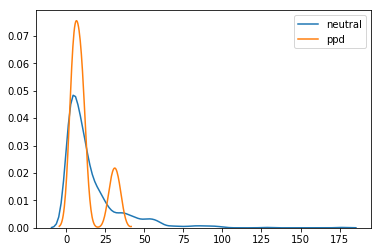

In [104]:
#plt.plot(new_data_bump2017['predict_type']=='ppd')

#sns.kdeplot((new_data_bump2017.comms_num[new_data_bump2017['predict_type'] == 'neutral']), label = 'neutral')
#sns.kdeplot((new_data_bump2017.comms_num[new_data_bump2017['predict_type'] == 'ppd']), label = 'ppd')


#sns.kdeplot((new_data_mommit.comms_num[new_data_mommit['predict_type'] == 'neutral']), label = 'neutral')
#sns.kdeplot((new_data_mommit.comms_num[new_data_mommit['predict_type'] == 'ppd']), label = 'ppd')



(-0.5, 399.5, 199.5, -0.5)

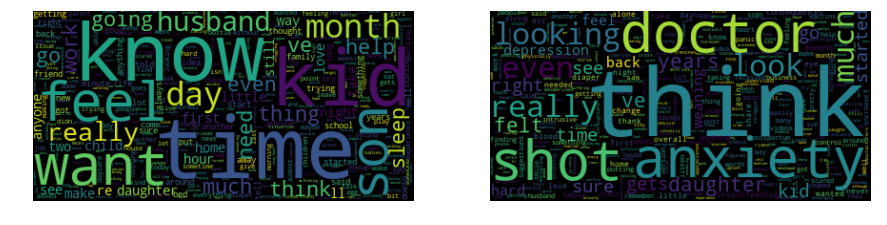

In [106]:
## Create word cloud
fig = plt.figure(figsize = (15,5))
ax = fig.subplots(1,2)


all_words = []
for bodytext in new_data_mommit[new_data_mommit['predict_type'] == 'neutral']['body']:
    all_words = all_words + preprocess(bodytext)
all_text = " ".join(all_words)
wordcloud = WordCloud(max_words=5000,margin=0).generate(all_text)

ax[0].imshow(wordcloud, interpolation="bilinear")
ax[0].axis("off")
#plt.show()

## Create word cloud
all_words = []
for bodytext in new_data_mommit[new_data_mommit['predict_type'] == 'ppd']['body']:
    all_words = all_words + preprocess(bodytext)
all_text = " ".join(all_words)
wordcloud = WordCloud(max_words=5000,margin=0).generate(all_text)
ax[1].imshow(wordcloud, interpolation="bilinear")
ax[1].axis("off")

In [66]:
new_data_mommit[new_data_mommit['predict_type'] == 'ppd']['title'].head()

Datetime
2018-10-25 15:16:50                     9 year old daughter has anxiety?
2018-10-24 19:35:33    His Dad Wants to Start Seeing Him After Six Mo...
2018-10-16 17:13:42    Moms who went back to work after baby, what wa...
2018-10-12 01:27:03         The 1 year anniversary of my traumatic birth
2018-09-25 02:47:55                                   Postpartum anxiety
Name: title, dtype: object